# Traffic Sign Recognition


Progetto del corso di Machine Learning AA 2017/2018

Corso di Laurea Magistrale in Informatica, Università di Bologna

- Ceccolini Enrico (matricola )
- Valguarnera Enrico (800115)


Il progetto consiste nell'analisi ed implementazione di alcune delle soluzioni presentate nel paper *Traffic Sign Recognition with Multi-Scale Convolutional Networks* redatto da Pierre Sermanet e Yann LeCun (reperibile [qui]('http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf')). Tale studio racchiude le tecniche principali avanzate da diversi team di ricercatori (tra cui il loro) durante le competizioni IJCNN, sfide che avevano come obiettivo la realizzazione del miglior classificatore di segnali stradali (single-image, multi-class classification problem) partendo dal dataset GTSRB, dataset che impareremo a conoscere.

Le soluzioni proposte da Sermanet e LeCun sono state implementate usando la libreria open-source EBLearn C++, sviluppata direttamente dagli autori del paper. Le nostre soluzioni fanno uso della libreria Keras per la definizione delle reti e del linguaggio Python. 

In particolare si è cercato di aderire alle tecniche proposte dal paper di: aumento del dataset, normalizzazione del dataset e di definizione delle reti neurali, proponendo alcune modifiche in ogni fase in modo da ottenere modelli più performanti.

Per quanto riguarda l'implementazione si è fatto riferimento a [questo](http://jokla.me/robotics/traffic-signs/) progetto, che presenta il nostro stesso obiettivo ma utilizza la libreri TensorFlow. 

# 1) Il Dataset GTSRB


Per uniformità al paper è stato scelto di utilizzare la versione del dataset indicata per l'*online competition stage*, non l'ultima presentata dall'istituto che si occupa delle competizioni. E' possibile ottenere il dataset [qui]('http://benchmark.ini.rub.de/index.php?section=gtsrb&subsection=dataset#Downloads').

Questa contiene 39209 immagini in totale, divise tra tra training-set (26,640 immagini) e test-set (12,569 immagini). Ogni immagine contiene un singolo segnale stradale appartenente ad una delle 43 classi presenti. Le dimensioni delle immagini variano da un minimo di 15x15 ad un massimo di 250x250 pixel.

Le immagini contenute nel dataset presentano le caratteristiche riscontrabili nel mondo reale dovute alle condizioni meteo, alla camera posta sul veicolo e alle condizioni fisiche del segnale stradale.

Le difficoltà riscontrate sono:
- diverse inquadrature,
- condizioni di luce (irradiazione, saturazione e basso contrasto),
- sfocature dovute al movimento del veicolo,
- danni fisici,
- graffiti e adesivi,
- bassa risoluzione. 

Per le suddette problematiche il dataset viene considerato rappresentativo per il problema.

#### Load del dataset e visualizzazione del dataset

Di seguito il plot di 43 immagini (una per classe) raffiguranti campioni scelti in modo casuale dal dataset.

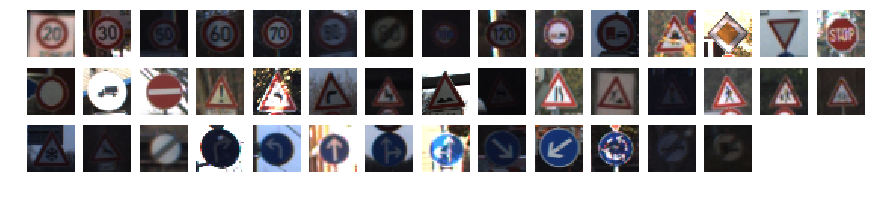

In [3]:
import my_mod_load as load
train, valid, test = load.load_train_valid_test()

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
load.display_sample_images(X_train, y_train)

#### Istogramma rappresentante la distribuzione di campioni per classe

Come è ben vidibile dal grafico, la quantità di campioni per classe è molto sbilanciata. Il paper non interviene su questa situazione con tecniche di bilanciamento tramite la creazione di nuovi campioni ottenendo comunque un' ottima accuratezza sul test-set.

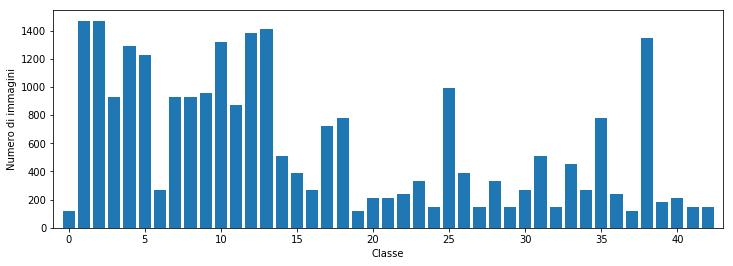

In [4]:
load.display_class_distribution(y_train)

# 2) Data Preparation

## 2.1) Valid-set

Come evdenzia il paper, la selezione delle immagini che popoleranno il validation dataset è cruciale in GTSRB. Mischiare le immagini e selezionare un sottoinsieme porterebbe ad avere un validation dataset troppo simile al training dataset e all'impossibilità di ottenere valori di performance del modello accurati.

Il motivo è da trovare nella tecnica utilizzata per ottenere le immagini del dataset. Le immagini sono state estratte da tracce video. Per ogni traccia il segnale stradale presente è stato catturato circa 30 volte con aumento progressivo della risoluzione a mano a mano che la videocamera si avvicinava al segnale.

Per la definizione del validation set si è estratta in maniera casuale una traccia per ognuna delle 43 classi, in modo da non avere immagini dello stesso identico segnale stradale nei diversi insiemi.

In [4]:
print("Dimensione del training-set: {}".format(len(X_train)))
print("Dimensione del valid-set: {}".format(len(X_valid)))

Dimensione del training-set: 25350
Dimensione del valid-set: 1290


## 2.2) Pre-processing

Per la fase di pre-processing è stata definita una collezione di funzioni, presente nel file my_mod_manipulate_image.py, utile per la normalizzazione e l'aumento dei dati.

### 2.2.1) Normalization

Per ottenere un modello con performance elevate Pierre Sermanet e Yann LeCun consigliano di:
- ridimensionare le immagini alla dimensione 32x32
- convertire lo spazio di colori da RGB a YUV
- applicare una normalizzazione globale sul canale Y
- apllicare una normalizzazione locale sul canale Y
- lasciare inalterati i canali U e V

**TODO - CONSIDERARE I COLORI!!!** Al termine del paper si legge che usare i canali colore non aumenta in modo considerevole l'accuratezza del modello generato, per questo motivo consideremo fin da subito la conversione in grayscale considerando solo il canale di luminanza con il vantaggio di poter realizzare reti più piccole e veloci.

Di seguito la funzione da noi utilizzata per la manipolazione di una singola immagine (le immagini sono state ridimensionate durante il caricamento del dataset).

``` Python
def normalize_img(img):
    # converte l'immagine in YUV mantenedo esclusivamente il canale Y (luminanza)
    img_y = cv2.cvtColor(img, (cv2.COLOR_BGR2YUV))[:,:,0]    
    # Normalizzazione globale
    # distribuisce la luminosità nell'istogramma incrementando il contrasto globale
    img_y = cv2.equalizeHist(img_y)     
    # rappresenta i valori in un range da 0 a 1
    img_y = (img_y / 255.).astype(np.float32)     
    # Equalizzazione locale
    # esegue la Contrast Limited Adaptive Histogram Equalization
    # l'obbiettivo è quello di enfatizzare gli angoli dei segnali stradali
    img_y = (exposure.equalize_adapthist(img_y) - 0.5)     
    img_y = img_y.reshape(img_y.shape + (1,))

    return img_y
```

#### Visualizzazione di un'immagine originale a confronto con una normalizzata


Using TensorFlow backend.


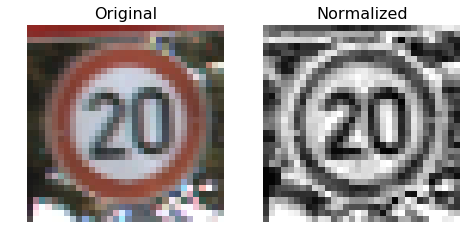

In [6]:
import plot_functions as pltfun
pltfun.original_vs_normalized(X_train[29])

### 2.2.2) Jittering
---
Per ottenere un modello con performance elevate Pierre Sermanet e Yann LeCun consigliano di aumentare i campioni del training-set andando a generare immagini da quelle già presenti.
Le trasformazioni da applicare devono generare segnali stradali plausibili, cioè che differiscano dagli originali per inquadratura della camera posta sull'eventuale veicolo.

Il paper consiglia di perturbare le immagini originali in modo casuale sulle seguenti proprietà con i relativi range:
- posizione ([-2, 2] pixels)
- scala ([.9, 1.1] ratio)
- rotazione ([-15, 15] gradi)

Per l'aumento dei dati è stata utilizzata la libreria Keras. In particolare tramite il modulo ImageDataGeneration. Nel ciclo for sottostante è riportata la generazione di un nuovo insieme di immagini delle stesse dimensioni del training set originario.


```Python
datagen = ImageDataGenerator(
        # perturbed in position ([-2, 2] pixels)
        width_shift_range=0.07, # for images 32x32
        height_shift_range=0.07,    
        # perturbed in scale ([.9, 1.1] ratio)
        # si è deciso di applicare uno zoom
        zoom_range=0.15,
        # perturbed in rotation ([-15, 15] degrees)
        rotation_range=15,
        fill_mode='nearest')

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=len(X_train)):
    X_train_aug = X_batch.astype('uint8')
    y_train_aug = y_batch
    break

```

### 2.2.3 Blurring
---
Per allenare il modello a riconoscere anche le immagini che presentano l'effetto di sfocatura dovuto al movimento del veicolo, si è deciso di aumentare i campioni del training-set aggiungendo un insieme di immagini corrispondente all'insieme originale al quale è stato applicato un blur.

E' stato utilizzato un kernel che calcola il valore medio e lo trasferisce in una particolare direzione. E' possibile verificare la tecnica [qui](https://www.packtpub.com/mapt/book/application_development/9781785283932/2/ch02lvl1sec21/motion-blur).

#### motion blur kernel utilizzato = 
\begin{bmatrix}
 0 & 0 & 0 \\
 1/4 & 1/4 & 1/4 \\
 0 & 0 & 0 \\
\end{bmatrix}

```Python
def motion_blur(img):
    size = 4
    # generating the kernel
    kernel_motion_blur = np.zeros((size, size))
    kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
    kernel_motion_blur = kernel_motion_blur / size
    img_bl = cv2.filter2D(img, -1, kernel_motion_blur)

    return img_bl
```

#### Visualizzazione di un'immagine originale a confronto con una sfocata e successivamente normalizzata.

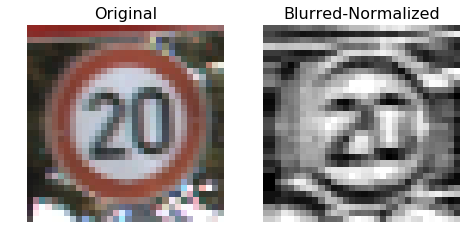

In [7]:
pltfun.orginal_vs_blurred(X_train[29])

#### Load del dataset manipolato

E' stato applicato il jittering cinque volte e il blurring una volta, ottenendo un fattore moltiplicativo x6.

Dimensione del training-set: 152100


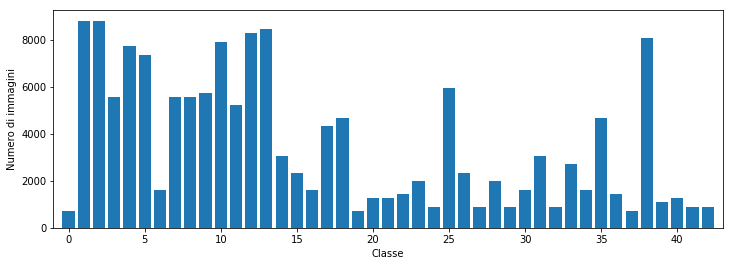

In [8]:
dirname = '2018-02-06_1645_online_augm_blur'

X_train_m, y_train_m = load.load_manipulated_train(dirname)
X_valid_m, y_valid_m = load.load_normalized_valid(dirname)
X_test_m, y_test_m = load.load_normalized_test(dirname)
print("Dimensione del training-set: {}".format(len(X_train_m)))

load.display_class_distribution(y_train_m)

## 3) Architecture

Il paper presenta diverse architetture. La principale (quella risultata più prestante) non corrisponde ad una classica rete convoluzionale dove i vari livelli si susseguono in maniera puramente sequenziale. Come si può notare dalla figura sotto, sono presenti dei collegamenti che saltano dei livelli, in modo da dare in pasto al classificatore tutti gli output dei vari stadi (con stadio si intende la sequenza: convoluzione, attivazione, pooling). Questo permette al classificatore di utilizzare caratteristiche globali (stadio 2, forme e strutture) e locali (stadio 1, dettagli più precisi).


Reti con questa architettura vengono definite ConvNet MS (Multi Scale).

![Rappresentazione visuale della rete](images/Figure_net.jpg)

#### La nostra implementazione della ConvNet MS

```Python
from keras.layers import Dense, Dropout, Flatten, merge
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.layers import Input, Dense
from keras.models import Model

net_name = "sol178ML"
features = [108, 108]
dense_hidden_units = [100]
dropouts = [0.2, 0.2, 0.5]

# input image
inputs = Input(shape=(32, 32, 1))

# Stage 1
# --------
# Prima convloluzione: 5x5 kernel, 1x1 stride, valid padding, outputs 28x28x108
first_layer = Convolution2D(nb_filter = features[0], nb_row = 5, nb_col = 5, border_mode='valid', subsample=(1, 1), activation='relu')(inputs)
# Max pooling: 2x2 stride, outputs 14x14x108
first_p_layer = MaxPooling2D(pool_size=(2, 2))(first_layer)
# Dropout: 0.2
drop_1 = Dropout(dropouts[0])(first_p_layer)

# Stage 2
# ----------
# Branch 1: 
# Max pooling: 2x2 stride, outputs 7x7x108
second_p_layer = MaxPooling2D(pool_size=(2, 2))(drop_1)
first_input_layer = Flatten()(second_p_layer)
# Branch 2: 
# Seconda convloluzione: 5x5 kernel, 1x1 stride, valid padding, outputs 10x10x108
second_layer = Convolution2D(nb_filter = features[1], nb_row = 5, nb_col = 5, border_mode='valid', subsample=(1, 1), activation='relu')(drop_1)
# Max pooling: 2x2 stride, outputs 5x5x108
third_p_layer = MaxPooling2D(pool_size=(2, 2))(second_layer)
# Dropout: 0.2
drop_2 = Dropout(dropouts[1])(third_p_layer)
second_input_layer = Flatten()(drop_2)

# Classifier
# ---------
# Merge the two branches
input_layer = merge([first_input_layer, second_input_layer], mode='concat', concat_axis=1)
# Fully connected layer: 100 neurons
hidden_layer = Dense(dense_hidden_units[0], activation='sigmoid')(input_layer)
# Dropout: 0.5
drop = Dropout(dropouts[2])(hidden_layer)
# Softmax: 43 neurons
predictions = Dense(43, activation='softmax')(drop)
model = Model(input=inputs, output=predictions)
```

Per completare l'architettura si è selezionata la funzione obiettivo, la tecnica di ottimizzazione e la metrica di valutazione.
- Come funzione obiettivo si è scelta la Keras Loss function categorical_crossentropy
- Come tecnica di ottimizzazione (optimizer) la Nesterov's Accelerated Gradient Descent
- Come metrica di valutazione la Keras Metric Accuracy

```Python
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler

# Stochastic gradient descent optimizer
sgd = SGD(lr=LR, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,
                metrics=['accuracy'],
                loss='categorical_crossentropy')
history_callback = model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(X_valid, y_valid)
```

## 4) Experiments

Sono state implementate le architetture che sono risultate più performanti. In particolare considereremo le soluzioni: \#178 (con le varie configurazioni), \#26 e \#27.

Le varie soluzioni sono state testate effettuando l'allenamento sul training-set non aumentato, aumentato (senza blur) e aumentato con blur. Tutti gli esperimenti considerano l'utilizzo del validation-set. Si è scelto di utilizzare inizialmente 40 epoche ed un learning rate di 0.01 e dropout dopo ogni livello.

Le tempistiche di allenamento per questa architettura risultano proibitive su sistemi non dotati di una scheda video dedicata al deep learning, per questo motivo si è utilizzato il servizio FloydHub.

I risultati sono presenti in tabella.


| Model id | Description (40 ep, 0.01 lr, 0.2-0.2-0.5 dropout)                              | No jitter (test acc.) | Jitter (test acc.) | Jitter + blur (test acc.) | Risultato paper (jitter only) |
| :------: | :--------------------------------------- | --------------------- | :----------------: | :-----------------------: | :-----------------: |
|   1     | LeNet-5 | 91.50%                 |       94.40%        |           95.70%           |        x        |
| 178_1  | 2LConvNet **MS** 108-108 + 100-feats CF classifier + No color | 96.96%                 |       99.02%        |           99.30%           |        99.17%        |
|  178_2   | 2LConvNet **MS** 108-200 + 100-feats CF classifier + No color | 96.84%                 |       99.03%        |           99.22%           |          98.85%          |
|  178_3   | 2LConvNet **MS** 108-108 + 100-feats CF classifier + No color | x                     |         x          |           99.23%           |          x          |
|    26    | 2LConvNet **MS** 38-64 + 100-feats CF classifier + No color | x                     |         x          |           98.87%           |          98.59%          |
|    27    | 26 **MS**                                | 97.00%                 |       99.08%        |           99.23%           |          98.20%          |



Dalla tabella si nota come l'aumento di dati del training-set presenti un forte impatto sulle performance. Nessun esperimento senza la data augmentation supera la human-performance (calcolata a 98.81%).

Aggiungendo i dati ottenuti tramite le tecniche di data augmentation presentata nella sezione 2.2.2 si ottiente una conferma dei risultati presentati nel paper.

Aggiungendo i dati ottenuti tramite la tecnica di blur presentata nella sezione 2.2.3 si ottiene sempre un impatto positivo sulle performance. La scelta di rappresentare le sfocature dovute alla ripresa in movimento è considerata vincente.

Selezionata la soluzione che si è rivelata più performante, si sono effettuati esperimenti su di essa variando gli iperparametri. Si è pensato di diminuire il learning rate e di aumentare il numero di epoche per ottenere in egual modo la convergenza. Impostando il learning rate a 0.001 il processo di apprndimento è risultato troppo lento non rispettando i tempi stabiliti dal nostro servizio di training online.
Si è allora aumentato a 0.005 e in 60 epoche si è ottenuto il risultato di 99.33%. 

| Model id | Description (60 ep, 0.005 lr, 0.2-0.2-0.5 dropout)| Jitter + blur (test acc.) | Risultato paper (jitter only) |
| :------: | :--------------------------------------- | --------------------- | :-----------------: |
| 178_1  | 2LConvNet **MS** 108-108 + 100-feats CF classifier + No color | 99.33%                  |        99.17%        |

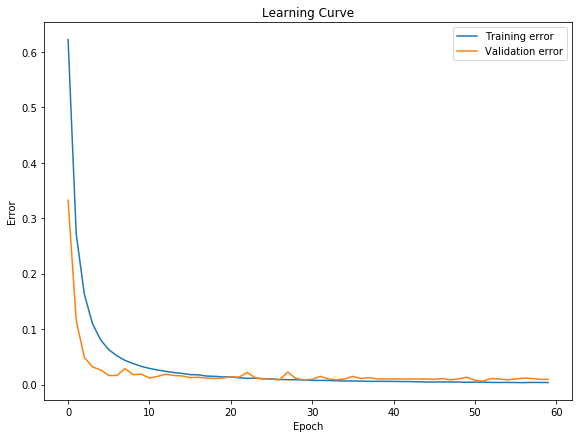

In [9]:
import matplotlib.pyplot as plt
loss = [2.3224931627539411, 0.95902063393106907, 0.57738807755344246, 0.39434895909279288, 0.29178112063142986, 0.22897101789418997, 0.18857483588928145, 0.15889979411433355, 0.13804240880750809, 0.1180983810006279, 0.10732530467961666, 0.095876461713428479, 0.086721210363838411, 0.080233926926687474, 0.074031192222310083, 0.066783223811887268, 0.064560208774706321, 0.05749144869602428, 0.054409973111780044, 0.051259197560797234, 0.050213574170478469, 0.045086306129961243, 0.042094643700238438, 0.041920874628687203, 0.039481534780316019, 0.037035269629281262, 0.034725656391738045, 0.033895712655667098, 0.032337658375080361, 0.031194487027015678, 0.029627290780286818, 0.028891097782779776, 0.027661715820970541, 0.0259268042128129, 0.02527161478802787, 0.024536348623073585, 0.023796881802140058, 0.022963473645726526, 0.022494881674304436, 0.022181936841516862, 0.021618605218190923, 0.020707600516445303, 0.02076324417770771, 0.020033975090687012, 0.018649663002543115, 0.01869819978647605, 0.01792058470451385, 0.018319762146723734, 0.01773924546146044, 0.016541514908068281, 0.016493280949897667, 0.016494886048669628, 0.015471078465734948, 0.014947991845412897, 0.015567468087152774, 0.014607676312898058, 0.014190136720325349, 0.014171103971228395, 0.015074903333044069, 0.014210410111098208]
accuracy = [0.37754109139665032, 0.72829059830000331, 0.83708086785323366, 0.89027613412072049, 0.91938856016249348, 0.93710716634577318, 0.94811965812749566, 0.95648257725651054, 0.96213675214145467, 0.96733070349552219, 0.97090072320841547, 0.97375410913872451, 0.97627218934911242, 0.97838264300586519, 0.97985535831689674, 0.98211702827871195, 0.98244575936883627, 0.98469428007889548, 0.98516765285996055, 0.98623931625028882, 0.9863510848235959, 0.98786982249617972, 0.98880999342537801, 0.98863905325443791, 0.98962524654832351, 0.98994740303529871, 0.99082182774490468, 0.99130834976988824, 0.99142011834319521, 0.99164365548980937, 0.99259040105193952, 0.99253780407626557, 0.99269559500015225, 0.99325443786982248, 0.99358316896778431, 0.99362261669953977, 0.99384615385712638, 0.99424720578566728, 0.99424063116370809, 0.99425378040762658, 0.99437212360289284, 0.99460223537616865, 0.99464168310322154, 0.994957264957265, 0.99539119000657461, 0.99543063773833007, 0.99544378698224856, 0.9954043392504931, 0.99554240631163704, 0.99592373438527282, 0.99571992110453644, 0.99571334648257726, 0.99619986850756082, 0.99631821170282708, 0.99618671926364233, 0.99636423405654173, 0.99659434583608764, 0.99617357001972384, 0.99629848783694941, 0.99638395792241941]
val_accuracy = [0.66744186028029573, 0.88449612403100775, 0.9511627906976744, 0.96821705426356586, 0.97364341085271322, 0.98372093023255813, 0.98372093023255813, 0.97131782945736433, 0.98217054263565895, 0.98139534883720925, 0.98837209302325579, 0.98527131782945732, 0.98139534883720925, 0.98372093023255813, 0.98449612403100772, 0.9875968992248062, 0.98682170542635661, 0.98837209302325579, 0.98914728682170538, 0.98837209302325579, 0.98604651162790702, 0.98682170542635661, 0.97829457364341088, 0.9875968992248062, 0.98992248062015509, 0.99069767441860468, 0.99147286821705427, 0.97751937984496129, 0.98914728682170538, 0.99147286821705427, 0.99069767441860468, 0.98527131782945732, 0.98992248062015509, 0.99147286821705427, 0.98992248062015509, 0.98527131782945732, 0.98914728682170538, 0.9875968992248062, 0.98992248062015509, 0.98992248062015509, 0.98992248062015509, 0.98992248062015509, 0.98992248062015509, 0.98992248062015509, 0.98992248062015509, 0.99069767441860468, 0.98914728682170538, 0.99147286821705427, 0.98992248062015509, 0.98682170542635661, 0.99224806201550386, 0.99379844961240305, 0.98914728682170538, 0.98992248062015509, 0.99147286821705427, 0.98992248062015509, 0.98837209302325579, 0.98914728682170538, 0.99069767441860468, 0.99069767441860468]

plt.figure(figsize=(8,6))
plt.title('Learning Curve')
#plt.plot([el for el in loss])
plt.plot([1 - el for el in accuracy])
plt.plot([1 - el for el in val_accuracy])
#plt.ylim([-.01,0.35])
#plt.legend(['Loss', 'Training error', 'Validation error'])
plt.legend(['Training error', 'Validation error'])
plt.tight_layout()
plt.savefig('images/learning_curve.png')
plt.ylabel('Error')
plt.xlabel('Epoch');


## 5) Test sulle nuove immagini


Per il test su nuove immagini sono stati selezionati dei segnali stradali per lo più situati nella città di Bologna. Le immagini sono state recuperate tramite Google Street View, cercando costituire un insieme rappresentativo per le caretteristiche di lontananza, inquadratura, luminosità, deterioramento e graffiti. 

Loaded model from disk

Testing: 
well-aimed: 27/31
well-aimed: 0.8710


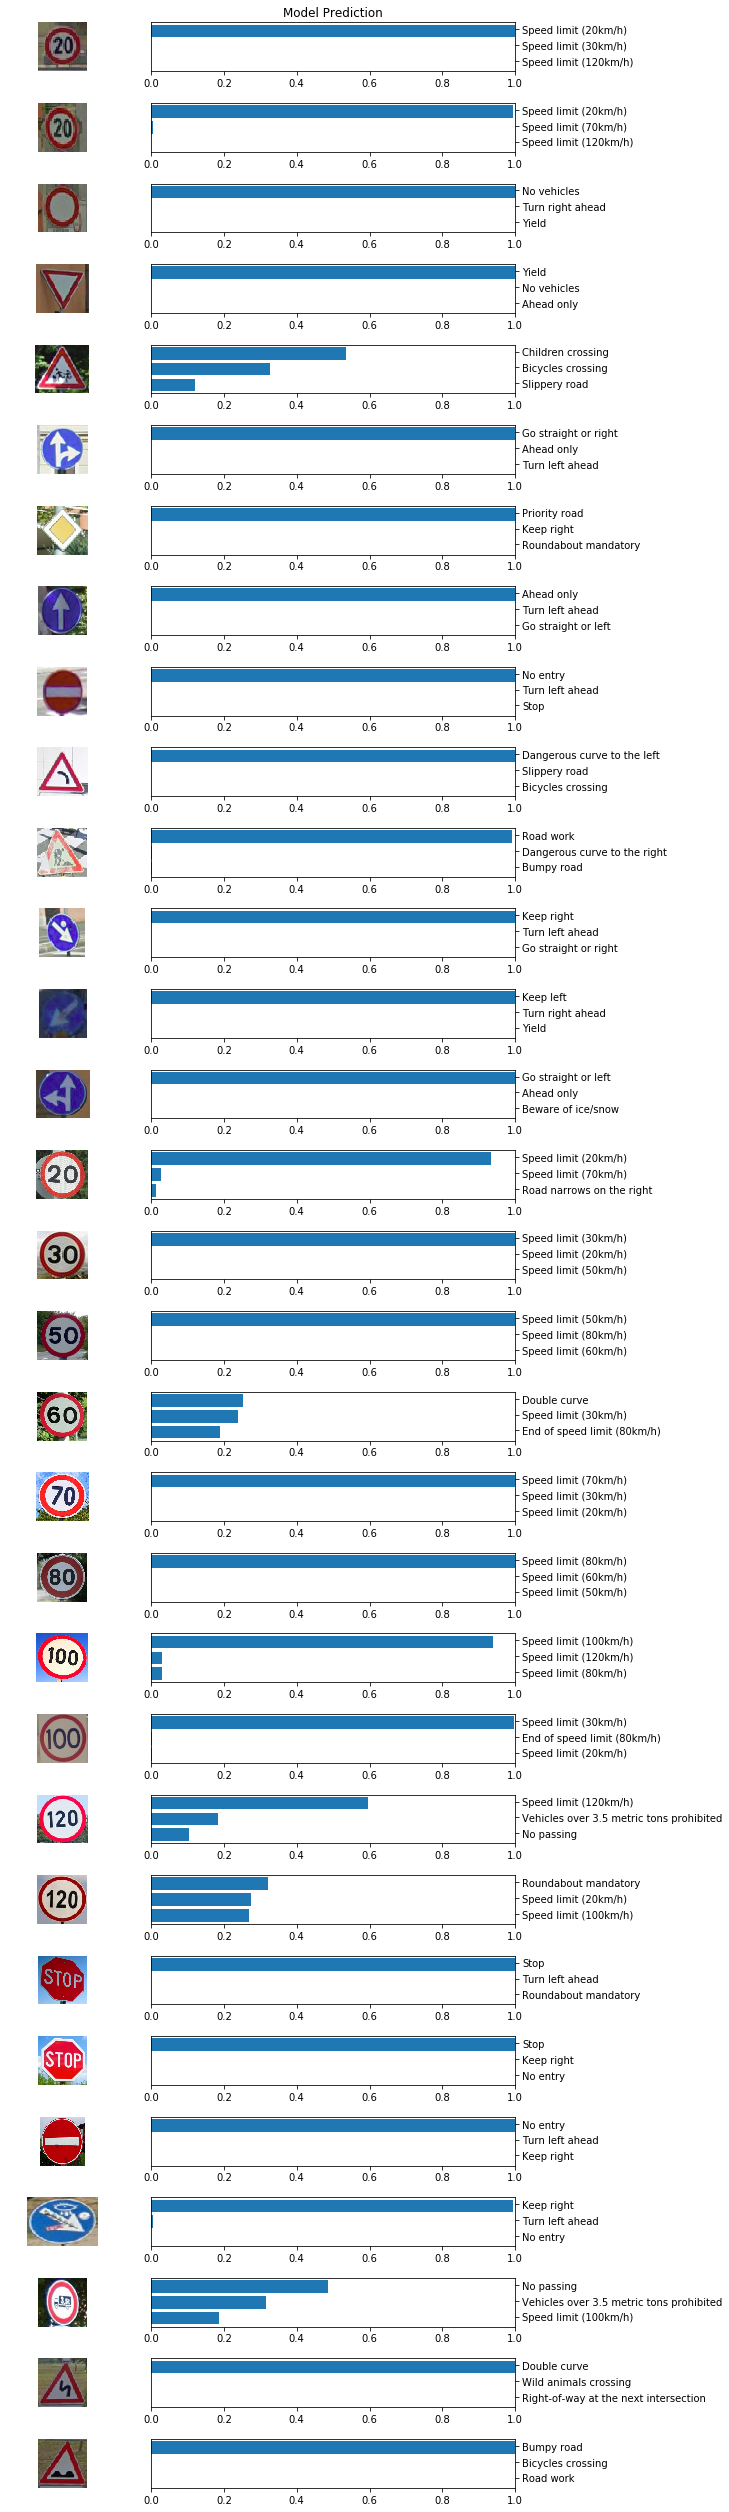

In [10]:
import plot_functions as pltfun
model = './final_models/keras/sol178_108-108MS/jitter-blur/model_108-108-100_ep40'
pltfun.final_image(model)

Il modello si comporta in modo ottimale. Dal test si nota come le immagini correttamente predette vengano collegate alla propria classe con probabilità prossima al 100%.


TODO: no elasticità

## 6) Conclusioni

- poche classi
- utilizzare ultima versione di GTSRB

## Bibliografia

[\[1\] GTSRB - Man vs. computer: Benchmarking machine learning algorithms for traffic sign recognition]('http://dx.doi.org/10.1016/j.neunet.2012.02.016')

[\[2\] OpenCV, EqualizeHist](https://docs.opencv.org/2.4/modules/imgproc/doc/histograms.html?highlight=equalizehist)

[\[3\] scikit-image, exposure.equalize_adapthist](http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_adapthist)

https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html